In [1]:
import baltic as bt
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
from scipy.stats import pearsonr

In [2]:
all_effects_tree_path = '../../data/titer-model/all-branch-effects/dengue_all_tree.json'
interserotype_effects_tree_path = '../../data/titer-model/interserotype-branch-effects/dengue_all_tree.json'

In [3]:
json_translation = {
    'name': 'strain',
    'height': 'xvalue',
}
full_all_effects_tree = bt.loadJSON(all_effects_tree_path, json_translation) ## baltic Tree object
full_interserotype_effects_tree = bt.loadJSON(interserotype_effects_tree_path, json_translation)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [4]:
all_effects_predictions = pd.read_csv('../../data/titer-model/all-branch-effects/titer_model_validation.csv', index_col=0)
interserotype_effects_predictions = pd.read_csv('../../data/titer-model/interserotype-branch-effects/titer_model_validation.csv', index_col=0)

(0, 4)

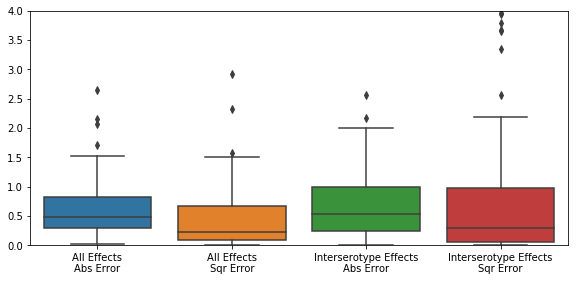

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
test_error = {}
test_error['All Effects\nAbs Error'] = np.abs(all_effects_predictions['predicted'] - all_effects_predictions['actual'])
test_error['All Effects\nSqr Error'] = (all_effects_predictions['predicted'] - all_effects_predictions['actual'])**2
test_error['Interserotype Effects\nAbs Error'] = np.abs(interserotype_effects_predictions['predicted'] - interserotype_effects_predictions['actual'])
test_error['Interserotype Effects\nSqr Error'] = (interserotype_effects_predictions['predicted'] - interserotype_effects_predictions['actual'])**2
test_error = pd.DataFrame(test_error)
sns.boxplot(data=test_error)
plt.tight_layout()
plt.ylim(0,4)

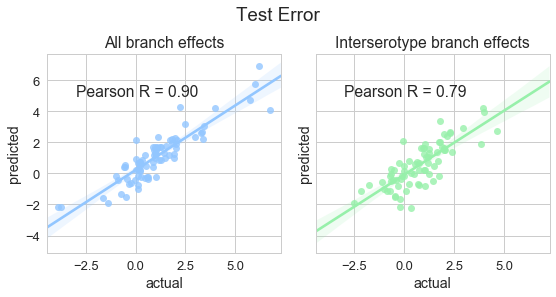

In [6]:
sns.set(style='whitegrid', font_scale=1.3, palette='pastel')
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))

sns.regplot('actual', 'predicted', data=all_effects_predictions, ax=axes[0])
all_effects_r = pearsonr(all_effects_predictions['actual'], all_effects_predictions['predicted'])[0]
axes[0].text(-3, 5, 'Pearson R = %.2f'%all_effects_r)
axes[0].set_title('All branch effects')

sns.regplot('actual', 'predicted', data=interserotype_effects_predictions, ax=axes[1])
interserotype_effects_r = pearsonr(interserotype_effects_predictions['actual'], interserotype_effects_predictions['predicted'])[0]
axes[1].text(-3, 5, 'Pearson R = %.2f'%interserotype_effects_r)
axes[1].set_title('Interserotype branch effects')

plt.suptitle('Test Error', va='bottom')
plt.tight_layout()
# plt.sup
# self.slope, self.intercept, tmpa, tmpb, tmpc = linregress(a[:,0], a[:,1])
# self.r2 = pearsonr(a[:,0], a[:,1])[0]**2


In [7]:
def plot_tree(tree, orientation = 'v', color=None):
    plt.yticks(size=0)
    branchWidth=2 ## default branch width
    ll = tree
    
    if color: ## Scale colorby trait for cmap
        cmap = cm.autumn_r
        max_cval = max([k.traits[color] for k in tree.Objects if color in k.traits])
        
    for k in ll.Objects: ## iterate over objects in tree      
        if orientation == 'v':
            x=k.x 
            y=k.y 

            xp=k.parent.x ## get x position of current object's parent
            if x==None: ## matplotlib won't plot Nones, like root
                x=0.0
            if xp==None:
                xp=x
        else:         ## If not a vertical plot, just flip x and y
            x = k.y
            y = -1*k.x

            xp = k.parent.y
            yp = k.parent.x
            if x == None:
                x = 0.
            if xp == None:
                xp = x
            if yp == None:
                yp = 0.
            yp = -1.*yp

        if color:
            c=cmap(k.traits[color]/max_cval) if k.traits.has_key(color) else 'gray'
        else:
            c = 'gray'
            
        if isinstance(k,bt.leaf):# or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            
            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
              
        if isinstance(k, bt.clade):
            s = 50
            pad = tree.treeHeight
            
            if orientation == 'v':
                plt.plot([x, pad], [y,y], lw=branchWidth, color=c, ls='--', zorder=9) # extend branches so tips line up
                plt.scatter(pad,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                plt.scatter(pad,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath

            else:
                pad = -1.*pad
                plt.plot([x,x],[y,pad], lw=branchWidth, color=c, ls='--', zorder=9)
                plt.scatter(x,pad,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
                plt.scatter(x,pad,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
                
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            if orientation == 'v':
                plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)
            else: ## Flip x and y for node.children coordinates, draw from top -> bottom (*-1)
                plt.plot([k.children[-1].y,k.children[0].y],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        
        if orientation == 'v':
            plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        else:
            plt.plot([x,x], [y,yp], lw=branchWidth, color=c, ls='-', zorder=9)

In [8]:
def antigenically_uniform(node, tree):
        
    node_cTiters = [round(k.traits['cTiter'], 2) for k in tree.traverse_tree(node, include_all=True) if k.traits.has_key('cTiter')]
    node_uniform = len(set(node_cTiters)) == 1
    
    parent_cTiters = [round(k.traits['cTiter'], 2) for k in tree.traverse_tree(node.parent, include_all=True) if k.traits.has_key('cTiter')]
    parent_uniform = len(set(parent_cTiters)) == 1
    
    if node_uniform==True and parent_uniform == False:
        return True
    else:
        return False
                          
def collapse_antigenic_phenotypes(tree):
    tree_copy = tree
    sorted_branches = sorted(tree_copy.nodes, key = lambda k: k.height, reverse=False)
    
    to_collapse = len(sorted_branches)
    for k in sorted_branches:
        if antigenically_uniform(k, tree_copy):
            tree_copy.collapseSubtree(k, k.traits['clade'], widthFunction=lambda x: 1)
        else:
            continue
    return tree_copy

all_effects_tree = collapse_antigenic_phenotypes(full_all_effects_tree)
interserotype_effects_tree = collapse_antigenic_phenotypes(full_interserotype_effects_tree)



In [9]:
def plot_tree_heatmap(tree, dTiters, title=None):
    sns.set(style='white', font_scale = 1.3)
    n = 4
    fig = plt.figure(figsize=(12,12))

    h_ratios = [n/3]
    h_ratios += [1 for i in range(n)]
    w_ratios = h_ratios + [.3]

    gs = gridspec.GridSpec(nrows=n+1, ncols=n+2, 
                           width_ratios = w_ratios, height_ratios=h_ratios)

    tree1 = plt.subplot(gs[1:, 0])
    plot_tree(tree)

    tree2 = plt.subplot(gs[0, 1:-1])
    plot_tree(tree, orientation='h')

    heatmap_ax = plt.subplot(gs[1:, 1:-1])
    heatmap_cbar_ax = plt.subplot(gs[1:, -1])
    sns.heatmap(dTiters, cmap='autumn_r', ax=heatmap_ax, cbar_ax=heatmap_cbar_ax, 
                xticklabels=False, yticklabels=False, square=True)
    
    if title:
        plt.suptitle(title, va='bottom')
    plt.tight_layout()

In [10]:
def trace_between(k1, k2):
    '''Naive path tracing; finds mrca of the two nodes, 
    traces each node backwards until it finds the mrca, 
    returns concatenated list of all nodes on that path'''
    
    k1_trace = []
    k2_trace = []
    
    k = k1 ## Trace from the node 1 to the root (in order)
    while k.index != 'Root':
        k1_trace.append(k)
        k = k.parent
        
    k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
    while k not in k1_trace:
        k2_trace.append(k)
        k = k.parent
    else:
#         node2_trace.append(k) # do not include mrca in trace
        mrca = k
        
    shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
    k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
    total_trace = []
    total_trace += shared_k1_trace
    total_trace += k2_trace
    
    return total_trace
    
def sum_attr(trace, attr='dTiter'):
    '''Collects all values of the passed attribute found 
    along the passed path through the tree'''
    if len(trace) == 0:
        return 0.
    return sum([i.traits[attr] for i in trace])


def find_all_dTiters(tree):
    antigenic_clades = [k for k in tree.Objects if isinstance(k, bt.clade)]
    clade_pairs = [sorted(c, key=lambda i: i.y) for c in combinations(antigenic_clades, 2)]
    dTiters = defaultdict(dict)

    for c0, c1 in clade_pairs:
        dt = sum_attr(trace_between(c0, c1))
        dTiters[c0.y][c1.y] = dt
        dTiters[c1.y][c0.y] = dt

    dTiters = pd.DataFrame(dTiters)
    return dTiters

all_effects_dTiters = find_all_dTiters(all_effects_tree)
interserotype_effects_dTiters = find_all_dTiters(interserotype_effects_tree)

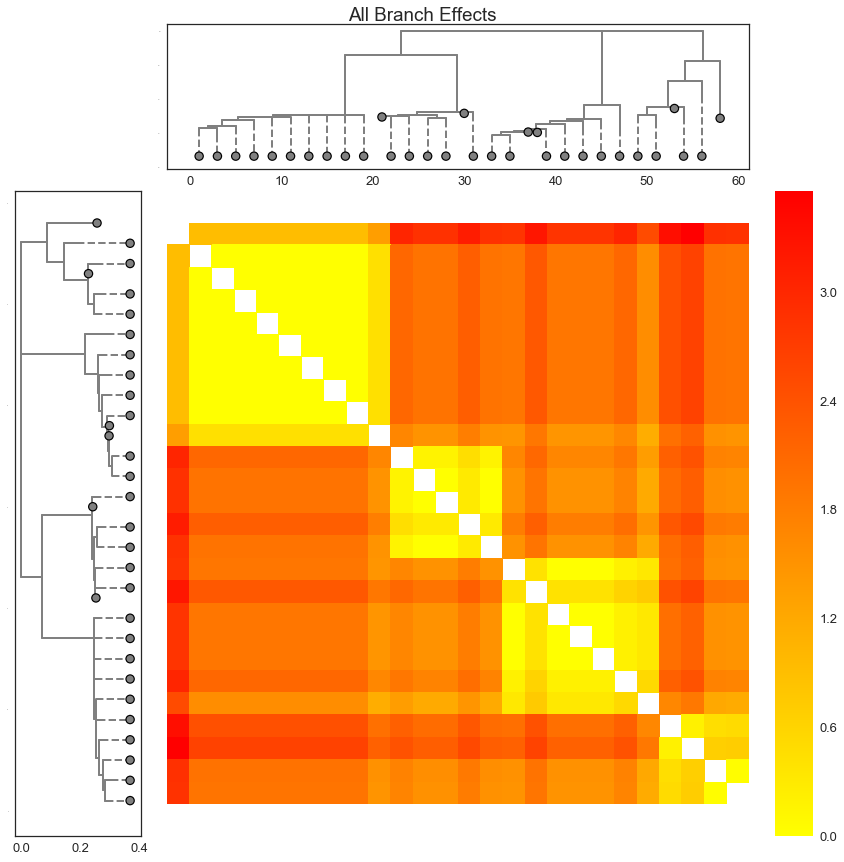

In [11]:
plot_tree_heatmap(all_effects_tree, all_effects_dTiters, title='All Branch Effects')

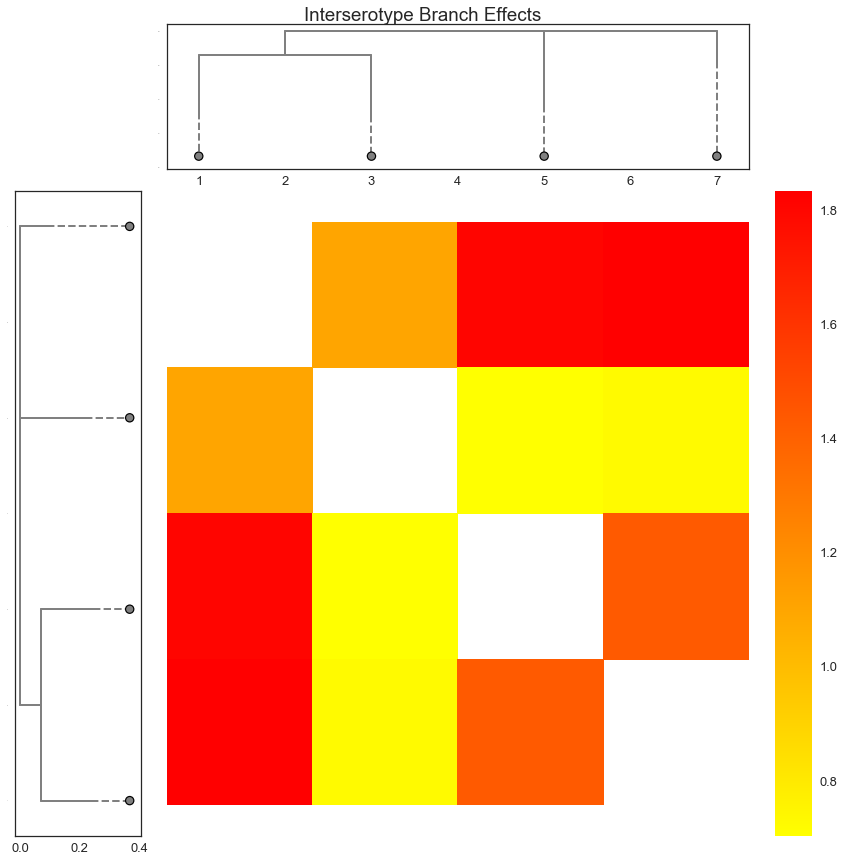

In [12]:
plot_tree_heatmap(interserotype_effects_tree, interserotype_effects_dTiters, title='Interserotype Branch Effects')